In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/CT-GAN-mini

!pwd

!pip install pydicom

import os
import numpy as np
from glob import glob

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as transforms

import pydicom
from skimage.transform import resize

# For mixed-precision training
from torch.amp import GradScaler, autocast

Mounted at /content/drive
/content/drive/MyDrive/CT-GAN-mini
/content/drive/MyDrive/CT-GAN-mini
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 68.1 MB/s eta 0:00:00


In [2]:
# Training hyperparameters
n_epochs = 50
batch_size = 4  # Reduced batch size to minimize memory usage
lr = 0.0002
b1 = 0.5  # Adam optimizer hyperparameter
b2 = 0.999  # Adam optimizer hyperparameter
img_size = 256  # Keeping original image size
ct_slices = 128  # Keeping original number of CT slices
channels = 1  # Number of image channels (grayscale)

In [3]:
# Dataset class
class XrayCTDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.patients = sorted(os.listdir(root_dir))
        # Filter out any files that are not directories
        self.patients = [p for p in self.patients if os.path.isdir(os.path.join(root_dir, p))]

    def __len__(self):
        return len(self.patients)

    def __getitem__(self, idx):
        patient_id = self.patients[idx]
        patient_dir = os.path.join(self.root_dir, patient_id)

        # Load and preprocess X-ray image
        xray_path = glob(os.path.join(patient_dir, 'Xray', '*.dcm'))[0]
        xray = self.load_and_preprocess_image(xray_path)

        # Load and preprocess CT slices
        ct_dir = os.path.join(patient_dir, 'CT')
        ct_slice_paths = sorted(glob(os.path.join(ct_dir, '*.dcm')))
        ct_slices_array = self.load_and_preprocess_ct_slices(ct_slice_paths)

        sample = {'xray': xray, 'ct': ct_slices_array}

        return sample

    def load_and_preprocess_image(self, image_path):
        # Load the image
        ds = pydicom.dcmread(image_path)
        image = ds.pixel_array.astype(np.float32)

        # Normalize the image
        image = (image - image.min()) / (image.max() - image.min())

        # Resize the image
        image = resize(image, (img_size, img_size), mode='constant', anti_aliasing=True)

        # Convert to tensor and add channel dimension
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)
        return image

    def load_and_preprocess_ct_slices(self, slice_paths):
        num_slices = len(slice_paths)
        desired_slices = ct_slices

        # Calculate indices to select slices for alignment
        indices = np.linspace(0, num_slices - 1, desired_slices).astype(int)

        # Preallocate a list for the CT slices
        ct_slices_list = []
        for idx in indices:
            p = slice_paths[idx]
            # Load and preprocess each slice
            slice_ = self.load_and_preprocess_image(p)
            ct_slices_list.append(slice_)

        # Stack slices into a 3D volume
        ct_slices_array = torch.stack(ct_slices_list, dim=0)  # Shape: [ct_slices, 1, img_size, img_size]
        ct_slices_array = ct_slices_array.squeeze(1)  # Shape: [ct_slices, img_size, img_size]
        ct_slices_array = ct_slices_array.unsqueeze(0)  # Shape: [1, ct_slices, img_size, img_size]

        return ct_slices_array  # Return shape: [1, ct_slices, img_size, img_size]


In [4]:
# Path to the dataset
dataset_root = 'LIDC-IDRI/'

# Create dataset and dataloader
dataset = XrayCTDataset(root_dir=dataset_root)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

In [5]:
# Define the Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        # Encoder: From [B, 1, 256, 256] to [B, 256, 16, 16]
        self.encoder = nn.Sequential(
            nn.Conv2d(channels, 32, kernel_size=4, stride=2, padding=1),   # [B, 32, 128, 128]
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),         # [B, 64, 64, 64]
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),        # [B, 128, 32, 32]
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),       # [B, 256, 16, 16]
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
        )

        # Bridge between encoder and decoder
        self.bridge = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),       # [B, 256, 16, 16]
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )

        # Decoder: Upsamples the features and depth dimension
        self.decoder = nn.Sequential(
            nn.ConvTranspose3d(256, 128, kernel_size=(4,4,4), stride=(2,2,2), padding=(1,1,1)),  # [B, 128, 2, 32, 32]
            nn.BatchNorm3d(128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose3d(128, 64, kernel_size=(4,4,4), stride=(2,2,2), padding=(1,1,1)),   # [B, 64, 4, 64, 64]
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),

            nn.ConvTranspose3d(64, 32, kernel_size=(4,4,4), stride=(2,2,2), padding=(1,1,1)),    # [B, 32, 8, 128, 128]
            nn.BatchNorm3d(32),
            nn.ReLU(inplace=True),

            nn.ConvTranspose3d(32, channels, kernel_size=(4,4,4), stride=(2,2,2), padding=(1,1,1)),  # [B, 1, 16, 256, 256]
            nn.Tanh(),
        )

        # Adjust the depth dimension to ct_slices
        # Upsample depth from 16 to ct_slices (128)
        self.depth_adjust = nn.ConvTranspose3d(
            channels, channels, kernel_size=(ct_slices // 16, 1, 1), stride=(ct_slices // 16, 1, 1)
        )

    def forward(self, x):
        x = self.encoder(x)                   # [B, 256, 16, 16]
        x = self.bridge(x)                    # [B, 256, 16, 16]
        x = x.unsqueeze(2)                    # [B, 256, 1, 16, 16]

        # Decoder: Upsample both spatial dimensions and depth
        x = self.decoder(x)                   # [B, 1, 16, 256, 256]
        x = self.depth_adjust(x)              # Upsample depth to ct_slices (128)
        return x


# Define the Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv3d(channels * 2, 32, kernel_size=4, stride=2, padding=1),    # [B, 32, D/2, 128, 128]
            nn.BatchNorm3d(32),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv3d(32, 64, kernel_size=4, stride=2, padding=1),          # [B, 64, D/4, 64, 64]
            nn.BatchNorm3d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv3d(64, 128, kernel_size=4, stride=2, padding=1),         # [B, 128, D/8, 32, 32]
            nn.BatchNorm3d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv3d(128, 256, kernel_size=4, stride=2, padding=1),        # [B, 256, D/16, 16, 16]
            nn.BatchNorm3d(256),
            nn.LeakyReLU(0.2, inplace=True),
        )

        # Output layers
        self.pool = nn.AdaptiveAvgPool3d((1, 1, 1))                         # [B, 256, 1, 1, 1]
        self.adv_layer = nn.Sequential(
            nn.Flatten(),                                                   # [B, 256]
            nn.Linear(256, 1),                                              # [B, 1]
        )

    def forward(self, ct, xray):
        # xray: [B, 1, img_size, img_size]
        # ct: [B, 1, ct_slices, img_size, img_size]
        # Expand xray along depth dimension to match ct_slices
        xray_expanded = xray.unsqueeze(2).repeat(1, 1, ct_slices, 1, 1)  # [B, 1, ct_slices, img_size, img_size]
        # Concatenate along channel dimension
        x = torch.cat([ct, xray_expanded], dim=1)  # [B, 2, ct_slices, img_size, img_size]

        x = self.model(x)
        x = self.pool(x)
        validity = self.adv_layer(x)
        return validity

In [6]:
# Function to count parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

# Print the number of parameters
print(f"Generator parameters: {count_parameters(generator)}")
print(f"Discriminator parameters: {count_parameters(discriminator)}")

Generator parameters: 4035914
Discriminator parameters: 2758305


In [7]:
# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generator.to(device)
discriminator.to(device)

# Loss function
adversarial_loss = nn.MSELoss()

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

# For mixed-precision training
scaler = GradScaler()
print(device)

cuda


In [ ]:
# Training loop
for epoch in range(n_epochs):
    for i, batch in enumerate(dataloader):
        xray = batch['xray'].to(device, non_blocking=True)
        ct = batch['ct'].to(device, non_blocking=True)

        valid = torch.ones((xray.size(0), 1), requires_grad=False).to(device)
        fake = torch.zeros((xray.size(0), 1), requires_grad=False).to(device)

        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()

        with autocast(device_type='cuda'):
            # Generate CT scans
            gen_ct = generator(xray)

            # Generator loss
            pred_gen = discriminator(gen_ct, xray)
            g_loss = 0.5 * adversarial_loss(pred_gen, valid)

        scaler.scale(g_loss).backward()
        scaler.step(optimizer_G)
        scaler.update()

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        with autocast(device_type='cuda'):
            # Real CT loss
            pred_real = discriminator(ct, xray)
            real_loss = 0.5 * adversarial_loss(pred_real, valid)
            # Fake CT loss
            pred_fake = discriminator(gen_ct.detach(), xray)
            fake_loss = 0.5 * adversarial_loss(pred_fake, fake)
            # Total discriminator loss
            d_loss = real_loss + fake_loss

        scaler.scale(d_loss).backward()
        scaler.step(optimizer_D)
        scaler.update()

        # Print training progress
        print(f"[Epoch {epoch+1}/{n_epochs}] [Batch {i+1}/{len(dataloader)}] "
              f"[D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")

    # Save the model checkpoints every 10 epochs
    if (epoch + 1) % 10 == 0:
        torch.save({
            'epoch': epoch + 1,
            'generator_state_dict': generator.state_dict(),
            'discriminator_state_dict': discriminator.state_dict(),
            'optimizer_G_state_dict': optimizer_G.state_dict(),
            'optimizer_D_state_dict': optimizer_D.state_dict(),
            'scaler_state_dict': scaler.state_dict(),
        }, f'model_checkpoint_epoch_{epoch+1}.pth')

# After training is done, save the final models and optimizers
torch.save({
    'epoch': n_epochs,
    'generator_state_dict': generator.state_dict(),
    'discriminator_state_dict': discriminator.state_dict(),
    'optimizer_G_state_dict': optimizer_G.state_dict(),
    'optimizer_D_state_dict': optimizer_D.state_dict(),
    'scaler_state_dict': scaler.state_dict(),
}, 'model_checkpoint.pth')

[Epoch 1/50] [Batch 1/48] [D loss: 0.3842] [G loss: 0.3807]
[Epoch 1/50] [Batch 2/48] [D loss: 0.8395] [G loss: 0.5640]
[Epoch 1/50] [Batch 3/48] [D loss: 0.5713] [G loss: 0.4687]
[Epoch 1/50] [Batch 4/48] [D loss: 0.4873] [G loss: 0.4221]
[Epoch 1/50] [Batch 5/48] [D loss: 0.3280] [G loss: 0.2984]
[Epoch 1/50] [Batch 6/48] [D loss: 0.3763] [G loss: 0.3118]
[Epoch 1/50] [Batch 7/48] [D loss: 0.2935] [G loss: 0.2663]
[Epoch 1/50] [Batch 8/48] [D loss: 0.3215] [G loss: 0.2726]
[Epoch 1/50] [Batch 9/48] [D loss: 0.2899] [G loss: 0.2527]
[Epoch 1/50] [Batch 10/48] [D loss: 0.2408] [G loss: 0.2392]
[Epoch 1/50] [Batch 11/48] [D loss: 0.2236] [G loss: 0.2447]
[Epoch 1/50] [Batch 12/48] [D loss: 0.2315] [G loss: 0.2403]
[Epoch 1/50] [Batch 13/48] [D loss: 0.2036] [G loss: 0.2451]
[Epoch 1/50] [Batch 14/48] [D loss: 0.2152] [G loss: 0.2556]
[Epoch 1/50] [Batch 15/48] [D loss: 0.1939] [G loss: 0.2345]
[Epoch 1/50] [Batch 16/48] [D loss: 0.1902] [G loss: 0.2060]
[Epoch 1/50] [Batch 17/48] [D los

In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim, peak_signal_noise_ratio as psnr

def visualize_results(generator, dataloader, device):
    generator.eval()
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            xray = batch['xray'].to(device, non_blocking=True)
            ct_real = batch['ct'].to(device, non_blocking=True)

            # Generate CT scans
            gen_ct = generator(xray)

            # Select the first sample from the batch
            xray_np = xray[0].squeeze().cpu().numpy()        # Shape: [img_size, img_size]
            ct_real_np = ct_real[0].squeeze().cpu().numpy()  # Shape: [ct_slices, img_size, img_size]
            gen_ct_np = gen_ct[0].squeeze().cpu().numpy()    # Shape: [ct_slices, img_size, img_size]

            # Print shapes for debugging
            print(f"xray_np.shape: {xray_np.shape}")
            print(f"ct_real_np.shape: {ct_real_np.shape}")
            print(f"gen_ct_np.shape: {gen_ct_np.shape}")

            # Select a slice to visualize (e.g., middle slice)
            slice_idx = ct_slices // 2
            ct_real_slice = ct_real_np[slice_idx]
            gen_ct_slice = gen_ct_np[slice_idx]

            # Calculate PSNR and SSIM for the selected slice
            psnr_value = psnr(ct_real_slice, gen_ct_slice, data_range=gen_ct_slice.max() - gen_ct_slice.min())
            ssim_value = ssim(ct_real_slice, gen_ct_slice, data_range=gen_ct_slice.max() - gen_ct_slice.min())

            # Plot X-ray, real CT slice, and generated CT slice
            fig, axs = plt.subplots(1, 3, figsize=(15, 5))
            axs[0].imshow(xray_np, cmap='gray')
            axs[0].set_title('Input X-ray')
            axs[0].axis('off')

            axs[1].imshow(ct_real_slice, cmap='gray')
            axs[1].set_title('Real CT Slice')
            axs[1].axis('off')

            axs[2].imshow(gen_ct_slice, cmap='gray')
            axs[2].set_title(f'Generated CT Slice\nPSNR: {psnr_value:.2f}, SSIM: {ssim_value:.4f}')
            axs[2].axis('off')

            plt.show()

            # Visualize only one sample
            break

In [9]:
def calculate_metrics(generator, dataloader, device):
    generator.eval()
    mse_total = 0.0
    psnr_total = 0.0
    ssim_total = 0.0
    num_slices = 0

    with torch.no_grad():
        for batch in dataloader:
            xray = batch['xray'].to(device, non_blocking=True)
            ct_real = batch['ct'].to(device, non_blocking=True)

            # Generate CT scans
            gen_ct = generator(xray)

            # Convert to numpy arrays
            ct_real_np = ct_real.cpu().numpy()  # Shape: [batch_size, 1, ct_slices, img_size, img_size]
            gen_ct_np = gen_ct.cpu().numpy()    # Shape: [batch_size, 1, ct_slices, img_size, img_size]

            # Remove singleton channel dimension
            ct_real_np = np.squeeze(ct_real_np, axis=1)  # Shape: [batch_size, ct_slices, img_size, img_size]
            gen_ct_np = np.squeeze(gen_ct_np, axis=1)    # Shape: [batch_size, ct_slices, img_size, img_size]

            # Loop over batch and slices
            batch_size = ct_real_np.shape[0]

            for b in range(batch_size):
                for s in range(ct_slices):
                    real_slice = ct_real_np[b, s]
                    gen_slice = gen_ct_np[b, s]

                    mse = np.mean((real_slice - gen_slice) ** 2)
                    psnr_value = psnr(real_slice, gen_slice, data_range=gen_slice.max() - gen_slice.min())
                    ssim_value = ssim(real_slice, gen_slice, data_range=gen_slice.max() - gen_slice.min())

                    mse_total += mse
                    psnr_total += psnr_value
                    ssim_total += ssim_value
                    num_slices += 1

    # Average the metrics
    mse_avg = mse_total / num_slices
    psnr_avg = psnr_total / num_slices
    ssim_avg = ssim_total / num_slices

    print(f"Average MSE: {mse_avg:.4f}")
    print(f"Average PSNR: {psnr_avg:.2f} dB")
    print(f"Average SSIM: {ssim_avg:.4f}")

xray_np.shape: (256, 256)
ct_real_np.shape: (128, 256, 256)
gen_ct_np.shape: (128, 256, 256)


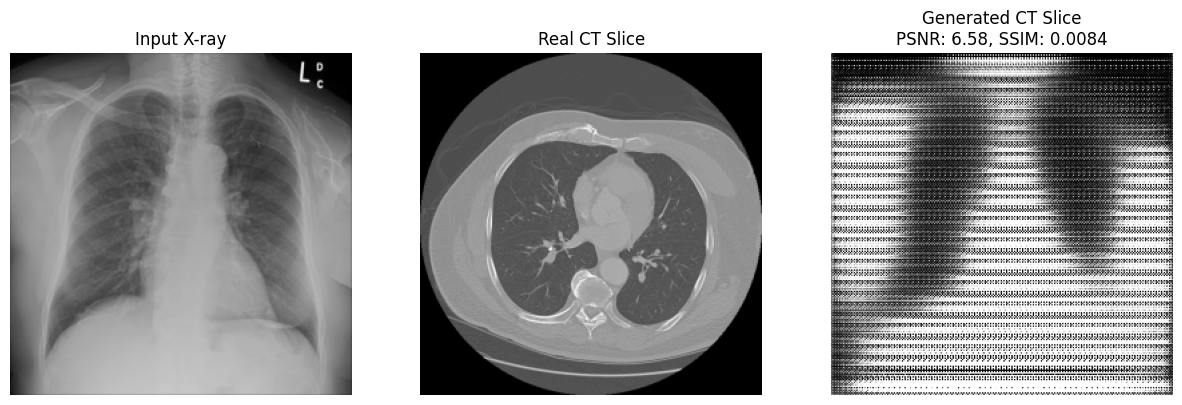

Average MSE: 0.0918
Average PSNR: 5.44 dB
Average SSIM: 0.0512


In [ ]:
# Visualize results
visualize_results(generator, dataloader, device)

# Calculate metrics
calculate_metrics(generator, dataloader, device)

# Semi-supervised Learning with ChestX-ray14

In [10]:
# Load the saved model checkpoint
checkpoint = torch.load('lsgan_model_checkpoint.pth', map_location=device)

# Load the state dictionaries into the models and optimizers
generator.load_state_dict(checkpoint['generator_state_dict'])
discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
optimizer_G.load_state_dict(checkpoint['optimizer_G_state_dict'])
optimizer_D.load_state_dict(checkpoint['optimizer_D_state_dict'])
scaler.load_state_dict(checkpoint['scaler_state_dict'])

# Optionally, set the starting epoch if you want to resume training
start_epoch = checkpoint['epoch']

# Ensure the generator is in evaluation mode if you're generating images
generator.eval()

<ipython-input-10-715dcfa8c5c2>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('lsgan_model_checkpoint.pth', map_location=device)


Generator(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (bridge): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), p

In [11]:
import os
import torch
import numpy as np
from skimage.transform import resize
from PIL import Image
from tqdm import tqdm  # For progress bar

# Ensure the generator is in evaluation mode
generator.eval()

# Path to the ChestX-ray14 dataset
chest_xray14_root = 'ChestX-ray14/'

# Directory to save the generated data
generated_data_root = 'LSGAN_Generated_LIDC-IDRI/'

# Create the root directory if it doesn't exist
os.makedirs(generated_data_root, exist_ok=True)

# Get the list of X-ray images
xray_image_paths = [os.path.join(chest_xray14_root, fname)
                    for fname in os.listdir(chest_xray14_root) if fname.endswith('.png')]

# Function to load and preprocess ChestX-ray14 images
def load_and_preprocess_chest_xray(image_path):
    # Load the image
    image = Image.open(image_path).convert('L')  # Convert to grayscale
    image = np.array(image).astype(np.float32)

    # Normalize the image
    image = (image - image.min()) / (image.max() - image.min())

    # Resize the image
    image = resize(image, (img_size, img_size), mode='constant', anti_aliasing=True)

    # Convert to tensor and add channel dimension
    image_tensor = torch.tensor(image, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    return image_tensor

# Iterate over the ChestX-ray14 images and generate CT slices
for idx, xray_image_path in tqdm(enumerate(xray_image_paths), total=len(xray_image_paths)):
    # Create a unique patient ID
    patient_id = f'ChestXray14_{idx+1:05d}'
    patient_dir = os.path.join(generated_data_root, patient_id)
    ct_dir = os.path.join(patient_dir, 'CT')
    xray_dir = os.path.join(patient_dir, 'Xray')
    os.makedirs(ct_dir, exist_ok=True)
    os.makedirs(xray_dir, exist_ok=True)

    # Load and preprocess the X-ray image
    xray_tensor = load_and_preprocess_chest_xray(xray_image_path).to(device)

    # Generate CT slices
    with torch.no_grad():
        gen_ct = generator(xray_tensor)

    # Convert generated CT to numpy array
    gen_ct_np = gen_ct.squeeze().cpu().numpy()  # Shape: [ct_slices, img_size, img_size]

    # Save generated CT slices
    for i in range(ct_slices):
        slice_image = gen_ct_np[i]  # Shape: [img_size, img_size]
        # Normalize and convert to uint16
        slice_image = (slice_image - slice_image.min()) / (slice_image.max() - slice_image.min())
        slice_image_uint16 = (slice_image * 65535).astype(np.uint16)
        # Save as PNG
        slice_filename = os.path.join(ct_dir, f'slice_{i:03d}.png')
        Image.fromarray(slice_image_uint16).save(slice_filename)

    # Save the preprocessed X-ray image
    xray_np = xray_tensor.squeeze().cpu().numpy()  # Shape: [img_size, img_size]
    xray_uint16 = (xray_np * 65535).astype(np.uint16)
    xray_filename = os.path.join(xray_dir, 'xray.png')
    Image.fromarray(xray_uint16).save(xray_filename)

100%|██████████| 200/200 [06:35<00:00,  1.98s/it]


In [12]:
# Modified Dataset class
class XrayCTDataset(Dataset):
    def __init__(self, root_dirs):
        self.patient_dirs = []
        for root_dir in root_dirs:
            patients = sorted(os.listdir(root_dir))
            patients = [p for p in patients if os.path.isdir(os.path.join(root_dir, p))]
            self.patient_dirs.extend([os.path.join(root_dir, p) for p in patients])

    def __len__(self):
        return len(self.patient_dirs)

    def __getitem__(self, idx):
        patient_dir = self.patient_dirs[idx]

        # Load and preprocess X-ray image
        xray_path = glob(os.path.join(patient_dir, 'Xray', '*'))[0]
        xray = self.load_and_preprocess_image(xray_path)

        # Load and preprocess CT slices
        ct_dir = os.path.join(patient_dir, 'CT')
        ct_slice_paths = sorted(glob(os.path.join(ct_dir, '*')))
        ct_slices_array = self.load_and_preprocess_ct_slices(ct_slice_paths)

        sample = {'xray': xray, 'ct': ct_slices_array}

        return sample

    def load_and_preprocess_image(self, image_path):
        # Check if the image is DICOM or PNG
        if image_path.endswith('.dcm'):
            # Load DICOM image
            ds = pydicom.dcmread(image_path)
            image = ds.pixel_array.astype(np.float32)
        else:
            # Load PNG image
            image = Image.open(image_path).convert('L')
            image = np.array(image).astype(np.float32)

        # Normalize the image
        image = (image - image.min()) / (image.max() - image.min())

        # Resize the image
        image = resize(image, (img_size, img_size), mode='constant', anti_aliasing=True)

        # Convert to tensor and add channel dimension
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)
        return image

    def load_and_preprocess_ct_slices(self, slice_paths):
        num_slices = len(slice_paths)
        desired_slices = ct_slices

        # Calculate indices to select slices for alignment
        indices = np.linspace(0, num_slices - 1, desired_slices).astype(int)

        # Preallocate a list for the CT slices
        ct_slices_list = []
        for idx in indices:
            p = slice_paths[idx]
            # Load and preprocess each slice
            slice_ = self.load_and_preprocess_image(p)
            ct_slices_list.append(slice_)

        # Stack slices into a 3D volume
        ct_slices_array = torch.stack(ct_slices_list, dim=0)  # Shape: [ct_slices, 1, img_size, img_size]
        ct_slices_array = ct_slices_array.squeeze(1)  # Shape: [ct_slices, img_size, img_size]
        ct_slices_array = ct_slices_array.unsqueeze(0)  # Shape: [1, ct_slices, img_size, img_size]

        return ct_slices_array  # Return shape: [1, ct_slices, img_size, img_size]

In [13]:
# Paths to the datasets
original_dataset_root = 'LIDC-IDRI/'
generated_dataset_root = 'LSGAN_Generated_LIDC-IDRI/'

# Create dataset and dataloader with both datasets
combined_dataset = XrayCTDataset(root_dirs=[original_dataset_root, generated_dataset_root])
combined_dataloader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

# Reinitialize the optimizers if necessary
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

In [15]:
# Set total number of epochs to train (70 epochs)
n_epochs = 70

# Training loop with the combined dataset
for epoch in range(start_epoch, n_epochs):
    for i, batch in enumerate(combined_dataloader):
        xray = batch['xray'].to(device, non_blocking=True)
        ct = batch['ct'].to(device, non_blocking=True)

        valid = torch.ones((xray.size(0), 1), requires_grad=False).to(device)
        fake = torch.zeros((xray.size(0), 1), requires_grad=False).to(device)

        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()

        with autocast(device_type='cuda'):
            # Generate CT scans
            gen_ct = generator(xray)

            # Generator loss
            pred_gen = discriminator(gen_ct, xray)
            g_loss = 0.5 * adversarial_loss(pred_gen, valid)

        scaler.scale(g_loss).backward()
        scaler.step(optimizer_G)
        scaler.update()

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        with autocast(device_type='cuda'):
            # Real CT loss
            pred_real = discriminator(ct, xray)
            real_loss = 0.5 * adversarial_loss(pred_real, valid)
            # Fake CT loss
            pred_fake = discriminator(gen_ct.detach(), xray)
            fake_loss = 0.5 * adversarial_loss(pred_fake, fake)
            # Total discriminator loss
            d_loss = real_loss + fake_loss

        scaler.scale(d_loss).backward()
        scaler.step(optimizer_D)
        scaler.update()

        # Print training progress
        print(f"[Epoch {epoch+1}/{n_epochs}] [Batch {i+1}/{len(combined_dataloader)}] "
              f"[D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")

# ---------------------
#  Save Model Checkpoint
# ---------------------
# After training is done, save the updated model checkpoint

torch.save({
    'epoch': n_epochs,  # Total number of epochs trained (should be 70)
    'generator_state_dict': generator.state_dict(),
    'discriminator_state_dict': discriminator.state_dict(),
    'optimizer_G_state_dict': optimizer_G.state_dict(),
    'optimizer_D_state_dict': optimizer_D.state_dict(),
    'scaler_state_dict': scaler.state_dict(),
}, 'semi_sup_lsgan_model_checkpoint.pth')

[Epoch 51/70] [Batch 1/98] [D loss: 0.0315] [G loss: 0.5421]
[Epoch 51/70] [Batch 2/98] [D loss: 0.1590] [G loss: 0.5298]
[Epoch 51/70] [Batch 3/98] [D loss: 0.0028] [G loss: 0.4408]
[Epoch 51/70] [Batch 4/98] [D loss: 0.0477] [G loss: 0.3041]
[Epoch 51/70] [Batch 5/98] [D loss: 0.0198] [G loss: 0.5268]


<ipython-input-12-4552ba6c9bc3>:41: RuntimeWarning: invalid value encountered in divide
  image = (image - image.min()) / (image.max() - image.min())
/usr/local/lib/python3.10/dist-packages/skimage/transform/_warps.py:738: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/usr/local/lib/python3.10/dist-packages/skimage/transform/_warps.py:742: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
/usr/local/lib/python3.10/dist-packages/skimage/transform/_warps.py:749: RuntimeWarning: All-NaN slice encountered
  and min_func(output_image) <= cval <= max_func(output_image)


[Epoch 51/70] [Batch 6/98] [D loss: nan] [G loss: nan]
[Epoch 51/70] [Batch 7/98] [D loss: 0.0704] [G loss: 0.5144]
[Epoch 51/70] [Batch 8/98] [D loss: 0.0851] [G loss: 0.5630]
[Epoch 51/70] [Batch 9/98] [D loss: 0.0151] [G loss: 0.3877]
[Epoch 51/70] [Batch 10/98] [D loss: 0.0765] [G loss: 0.1978]
[Epoch 51/70] [Batch 11/98] [D loss: 0.0238] [G loss: 0.4347]
[Epoch 51/70] [Batch 12/98] [D loss: 0.0300] [G loss: 0.4150]
[Epoch 51/70] [Batch 13/98] [D loss: 0.0288] [G loss: 0.5058]
[Epoch 51/70] [Batch 14/98] [D loss: 0.0185] [G loss: 0.4794]
[Epoch 51/70] [Batch 15/98] [D loss: 0.0480] [G loss: 0.4750]
[Epoch 51/70] [Batch 16/98] [D loss: 0.0304] [G loss: 0.4273]
[Epoch 51/70] [Batch 17/98] [D loss: 0.0648] [G loss: 0.4502]
[Epoch 51/70] [Batch 18/98] [D loss: 0.0508] [G loss: 0.6220]
[Epoch 51/70] [Batch 19/98] [D loss: 0.0383] [G loss: 0.5512]
[Epoch 51/70] [Batch 20/98] [D loss: 0.0193] [G loss: 0.4360]
[Epoch 51/70] [Batch 21/98] [D loss: 0.0202] [G loss: 0.3357]
[Epoch 51/70] [Bat

xray_np.shape: (256, 256)
ct_real_np.shape: (128, 256, 256)
gen_ct_np.shape: (128, 256, 256)


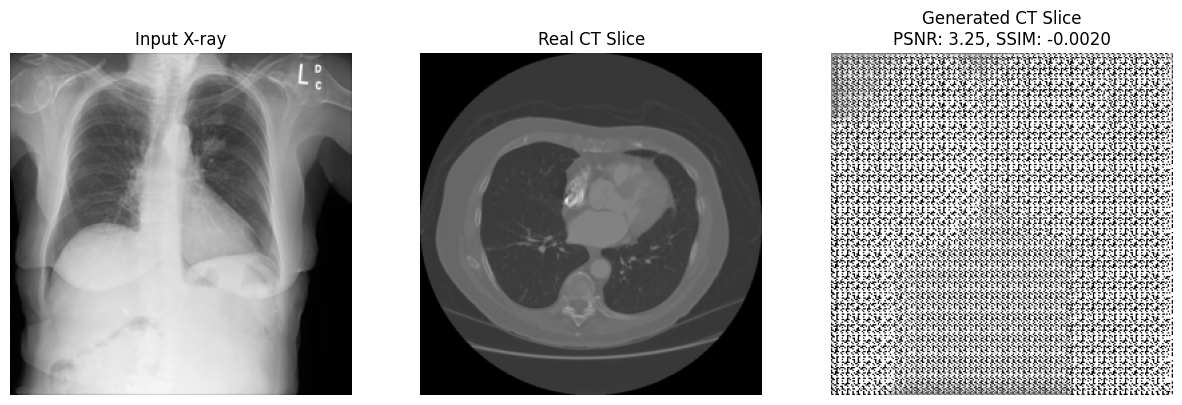

Average MSE: 0.3505
Average PSNR: -3.80 dB
Average SSIM: -0.0031


In [ ]:
# Visualize results
visualize_results(generator, dataloader, device)

# Calculate metrics
calculate_metrics(generator, dataloader, device)